In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from joblib import Parallel, delayed
from proximalde.gen_data import gen_data_complex
from proximalde.proximal import proximal_direct_effect, ProximalDE

# Running a Single Experiment

In [3]:
def exp_res(it, n, pw, pz, px, a, b, c, d, e, f, g, *,
            dual_type='Z', n_splits=5, semi=False, multitask=False, n_jobs=-1):
    np.random.seed(it)
    # M is unobserved so we omit it from the return variables
    W, D, _, Z, X, Y = gen_data_complex(n, pw, pz, px, a, b, c, d, e, f, g)
    return proximal_direct_effect(W, D, Z, X, Y,
                                  dual_type=dual_type,
                                  cv=n_splits, semi=semi,
                                  multitask=multitask, n_jobs=n_jobs,
                                  random_state=it)

In [4]:
a = .3
b = .6
c = .5 # this is the direct effect we want to estimate
d = .7
e = .5 # if the product of e*f is small, then we have a weak instrument
f = .5 # if the product of e*f is small, then we have a weak instrument
g = .9

In [5]:
n = 10000
pw = 10
pz, px = 5, 5
n_splits = 3
point, stderr, r2D, r2Z, r2X, r2Y, jac, point_pre, stderr_pre = exp_res(3, n, pw, pz, px, a, b, c, d, e, f, g,
                                                 dual_type='Z', n_splits=n_splits, semi=True)
pd.DataFrame({'point': point, 'se': stderr, 'r2D': r2D, 'r2Z': r2Z, 'r2X': r2X, 'r2Y': r2Y, 'Jacobian': jac,
              'point_pre': point_pre, 'se_pre': stderr_pre}, index=[0])

Residualizing D...
Residualizing Z...
Residualizing X...
Residualizing Y...


,point,se,r2D,r2Z,r2X,r2Y,Jacobian,point_pre,se_pre
0,0.52085,0.036443,0.364875,0.590347,0.539315,0.615116,94.94088,0.500012,0.035468


### Using the ProximalDE Estimator Class

In [6]:
np.random.seed(3)
W, D, _, Z, X, Y = gen_data_complex(n, pw, pz, px, a, b, c, d, e, f, g)
est = ProximalDE(dual_type='Z', cv=3, semi=True, multitask=False, n_jobs=-1, random_state=3)
est.fit(W, D, Z, X, Y)

Residualizing D...
Residualizing Z...
Residualizing X...
Residualizing Y...


ProximalDE(cv=3, random_state=3)

#### Summary of estimation results with diagnostic tests

In [8]:
est.summary(decimals=5)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Parameter Summary                      
============================================================
       point   stderr  zstat      pvalue   ci_lower ci_upper
------------------------------------------------------------
param 0.52085 0.03644 14.29199 2.45499e-46  0.44942  0.59228
R^2 of W-Residual Nuisance Models
=================================
    r2D     r2Z     r2X     r2Y  
---------------------------------
0 0.36487 0.59035 0.53932 0.61512
 Tests for weak ID and moment violation 
========================================
                   statistic   p-value  
----------------------------------------
id_strength^1       94.94088      0.e+00
primal_violation^2   0.81471 4.15241e-01
dual_violation^3     0.99359 3.20423e-01
                        Weak IV tests                         
==============================================================
              statistic   df1 df2  Keff p-value critical-value
--------------------------------------------------------------
F-nonrobust 2356389.38336   1 9998  N/A  0.e+00            N/A
F-robust    2480193.50757   1 9998  N/A  0.e+00            N/A
F-effective 2480193.50757 N/A  N/A  1.0     N/A       23.10851
--------------------------------------------------------------

With $\epsilon=\tilde{Y} - \tilde{X}^\top \eta - \tilde{D}c$ and $V=\tilde{D} - \gamma^\top \tilde{Z}$
1. Identification strength $\frac{\sqrt{n} E_n[\tilde{D} V]}{Std_n(\tilde{D} V)}$ (ideally above 2): 94.94088
2. Maximum violation of primal moments $\frac{\sqrt{n} E_n[\epsilon V]}{Std_n(\epsilon V)}$ (ideally below 2): 0.81471
3. Maximum violation of dual moments $\frac{\sqrt{n} E_n[V \tilde{X}]}{Std_n(V \tilde{X})}$ (ideally below 2): 0.99359
"""

#### Confidence Intervals and Robust Confidence Intervals

In [9]:
est.conf_int(alpha=.05) # 95% confidence interval

(0.4494220116919624, 0.5922778696897412)

In [10]:
# 95% confidence interval, robust to weak identification
est.robust_conf_int(alpha=0.05, lb=.1, ub=1.0, ngrid=1000)

(0.4495495495495495, 0.591891891891892)

#### Unusual Data Diagnostics

In [11]:
diag = est.run_diagnostics()

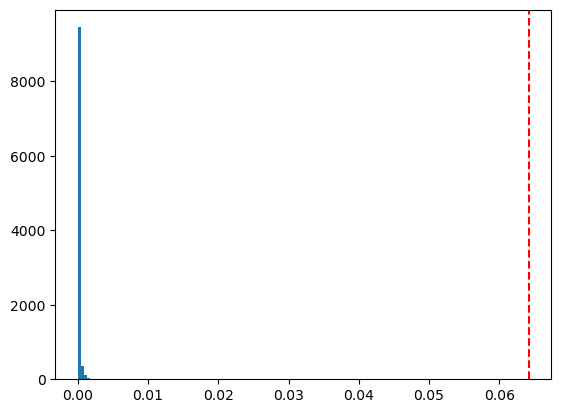

In [12]:
diag.cookd_plot()
plt.show()

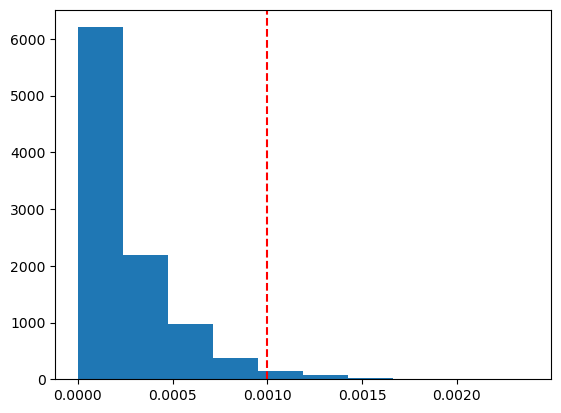

In [13]:
diag.l2influence_plot()
plt.show()

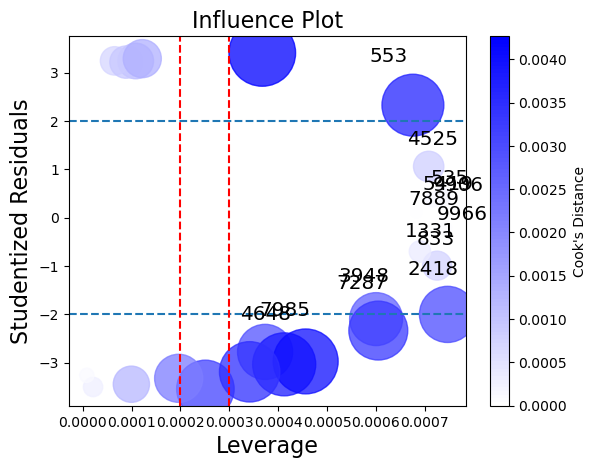

In [14]:
diag.influence_plot(influence_measure='cook', npoints=10)
plt.show()

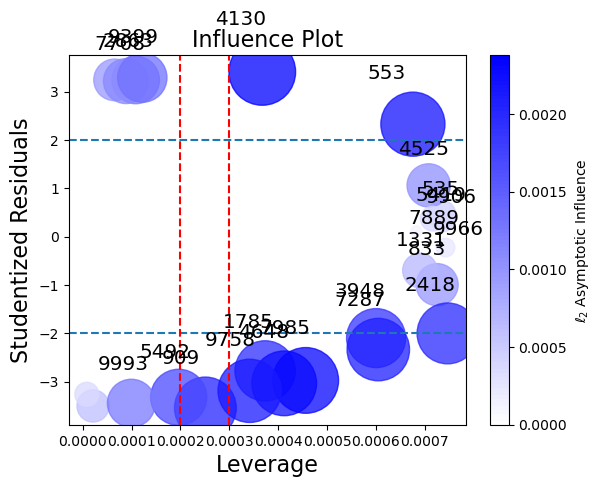

In [15]:
diag.influence_plot(influence_measure='l2influence', npoints=10)
plt.show()

### Subsample-Based Inference

In [16]:
inf = est.bootstrap_inference(stage=3, n_subsamples=1000, fraction=0.5, replace=False, verbose=3, random_state=123)
inf.summary()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 115 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.0s finished


,point,stderr,ci_lower,ci_upper
param,0.521,0.035,0.452,0.585


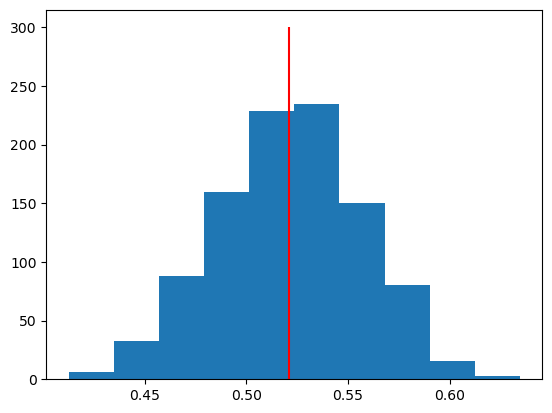

In [17]:
plt.hist(inf.point_dist)
plt.vlines([inf.point], 0, 300, color='r')
plt.show()

In [18]:
inf = est.bootstrap_inference(stage=2, n_subsamples=1000, fraction=0.5, replace=False, verbose=3, random_state=123)
inf.summary()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.2min finished


,point,stderr,ci_lower,ci_upper
param,0.521,0.051,0.419,0.614


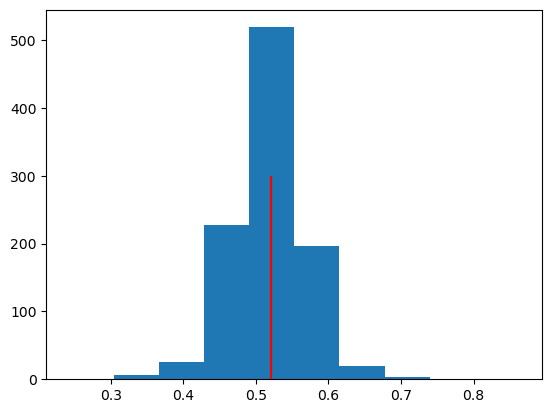

In [19]:
plt.hist(inf.point_dist)
plt.vlines([inf.point], 0, 300, color='r')
plt.show()

In [19]:
inf = est.bootstrap_inference(stage=1, n_subsamples=1000, fraction=0.5, replace=False, verbose=3, random_state=123)
inf.summary()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.3min finished


,point,stderr,ci_lower,ci_upper
param,0.526,0.05,0.412,0.611


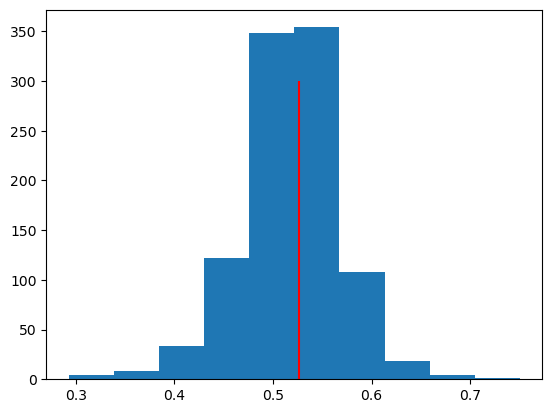

In [20]:
plt.hist(inf.point_dist)
plt.vlines([inf.point], 0, 300, color='r')
plt.show()

In [21]:
inf.summary(pivot=True)

,point,stderr,ci_lower,ci_upper
param,0.526,0.05,0.441,0.64


# Coverage Experiment

In [22]:
n = 10000
pw = 10
pz, px = 30, 30
n_splits = 3

results = Parallel(n_jobs=-1, verbose=3)(delayed(exp_res)(i, n, pw, pz, px, a, b, c, d, e, f, g,
                                                           n_splits=n_splits, semi=True, n_jobs=1)
                                          for i in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.

KeyboardInterrupt



#### Summarize

In [ ]:
points_base, stderrs_base, rmseD, rmseZ, rmseX, rmseY, jac, points_alt, stderrs_alt = zip(*results)
points_base = np.array(points_base)
stderrs_base = np.array(stderrs_base)
points_alt = np.array(points_alt)
stderrs_alt = np.array(stderrs_alt)

for points, stderrs in [(points_base, stderrs_base), (points_alt, stderrs_alt)]:
    coverage = np.mean((points + 1.96 * stderrs >= c) & (points - 1.96 * stderrs <= c))
    rmse = np.sqrt(np.mean((points - c)**2))
    bias = np.abs(np.mean(points) - c)
    std = np.std(points)
    mean_stderr = np.mean(stderrs)
    mean_length = np.mean(2 * 1.96 * stderrs)
    median_length = np.median(2 * 1.96 * stderrs)
    print(f"Coverage: {coverage:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"Bias: {bias:.3f}")
    print(f"Std: {std:.3f}")
    print(f"Mean CI length: {mean_length:.3f}")
    print(f"Median CI length: {mean_length:.3f}")
    print(f"Mean Estimated Stderr: {mean_stderr:.3f}")
    print(f"Nuisance R^2 (D, Z, X, Y): {np.mean(rmseD):.3f}, {np.mean(rmseZ):.3f}, {np.mean(rmseX):.3f}, {np.mean(rmseY):.3f}")

In [ ]:
plt.hist(points_base, label='Distribution of Estimates: debiased')
plt.hist(points_alt, label='Distribution of Estimates: original', alpha=.3)
plt.vlines([c], 0, plt.ylim()[1], color='red', label='truth')
plt.legend()
plt.show()